In [1]:
import sympy as sym
import scipy.sparse as sp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex, clear_output
from time import sleep
#%matplotlib notebook

In [2]:
def plot_sol_in_time(t,x,sol,exact_sol = None,wait=0.001):
    _min = sol.min()
    _max = sol.max() + (sol.max()/10)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    step = len(t) // 200
    for i in range(0,len(t)-1,step):
        ax.cla()
        ax.title.set_text("Time: " + str(round(t[i],3)) + " s")  
        ax.plot(x, sol[i],label="numerical solution")
        if exact_sol is not None:
            ax.plot(x,np.vectorize(exact_sol)(t[i],x),label="exact solution")
            plt.legend()
        ax.set_xlim(0, x.max())
        ax.set_ylim(_min, _max)
        display(fig)
        clear_output(wait = True)
        sleep(wait)

In [3]:
def plot_sol_in_3d(t,x,sol):
    X, Y = np.meshgrid(x, t)
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection='3d')
    ax.view_init(30, -110)
    ax.plot_surface(X, Y, sol, rstride=1, cstride=1,cmap='jet', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('z')

# Advection problem

In [5]:
class ad_pb_fd_method:
    
    def __init__(self, alpha, u_0, g, a = 0, b = 1, T = 1):
        self.a = a
        self.b = b
        self.T = T
        self.alpha = alpha
        self.u_0 = u_0
        self.g = g
        self.name = "Finite Difference method for the advection problem"
    
    def h(self):
        return (self.b - self.a)/self.N_x
        
    def tau(self):
        return self.T/self.N_t
    
    def x_array(self):
        return np.linspace(self.a,self.b,self.N_x)
    
    def t_array(self):
        return np.linspace(0,self.T,self.N_t)
    
    def courant_number(self):
        max_abs_alpha = max([abs(self.alpha(t,x)) for x in self.x_array() for t in self.t_array()])
        return max_abs_alpha * self.tau() / self.h()
    
    def index_at_t(self, t):
        assert t >= 0 and t < self.T
        return int(t/self.tau())
    
    def index_at_x(self, x):
        assert x >= self.a and x < self.b 
        return int((x - self.a)/self.h())
    
    def compute_solution(self):
        pass

## Upwind method

In [6]:
class upwind(ad_pb_fd_method):
    
    def __init__(self, alpha, u_0, g, a = 0, b = 1, T = 1):
        super().__init__(alpha, u_0, g, a, b, T)
        self.name = "Upwind"
        
    def compute_solution(self):
        
        if self.courant_number() > 1:
            print("The method is unstable! CFL number = ", self.courant_number())
            
        U = np.zeros((self.N_t, self.N_x))
        coeffs = []
        indexes = []
        
        u_0_np = np.vectorize(self.u_0)
        g_np = np.vectorize(self.g)
        U[0,:] = u_0_np(self.x_array())
        #bc = 0 if self.alpha(0,0) >= 0 else self.N_x - 1
        U[:,0] = g_np(self.t_array())
        U[:,-1] = g_np(self.t_array())
        A = sp.lil_matrix((self.N_x,self.N_x))
        
        for n in range(1,self.N_t):
            for j in range(self.N_x):
                eta = self.alpha(n*self.tau(),self.a + j*self.h()) * self.tau() / self.h()
                A[j,j] = 1-abs(eta)
                if eta >= 0:
                    if j > 0:
                        A[j,j-1] = eta
                else:
                    if j < self.N_x - 1:
                        A[j,j+1] = -eta
            U[n,:] = A.dot(U[n-1,:])
            U[n,0] = self.g(self.tau() * n)
            U[n,-1] = self.g(self.tau() * n)
        
        return U

In [7]:
def u_0(x):
    return 10**4*(0.1 - x)**2*(0.2-x)**2 if 0.1 < x and x < 0.2 else 0.0
g = lambda x : 0
def alpha(t,x):
    return 0.7
def exact_sol(t,x):
    return u_0(x - 0.7*t)

In [8]:
um = upwind(alpha,u_0,g)

um.N_x = 285
um.N_t = 200

x = um.x_array()
t = um.t_array()

U_up = um.compute_solution()

print(um.courant_number())

0.9974999999999998


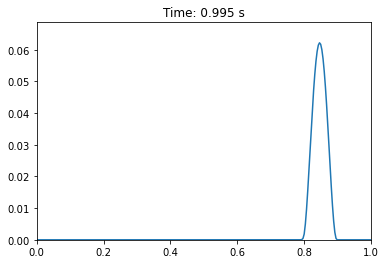

In [9]:
plot_sol_in_time(t,x,U_up)

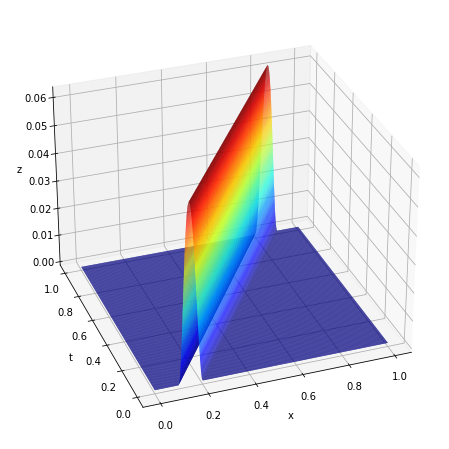

In [10]:
plot_sol_in_3d(t,x,U_up)

In [11]:
um.N_t = 200
um.N_x = 293

x = um.x_array()
t = um.t_array()

U = um.compute_solution()

print(um.courant_number())

The method is unstable! CFL number =  1.0254999999999999
1.0254999999999999


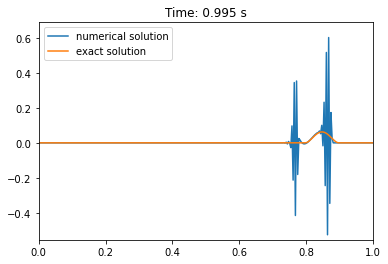

In [12]:
plot_sol_in_time(t,x,U,exact_sol)

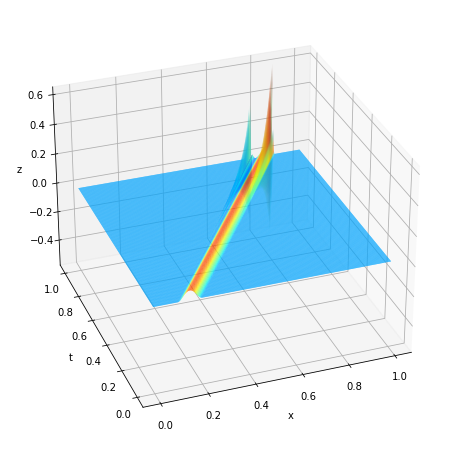

In [13]:
plot_sol_in_3d(t,x,U)

In [14]:
def u_0(x):
    return 0.05 if 0.1 < x and x < 0.3 else 0.0

um.u_0 = u_0

um.N_x = 285
um.N_t = 200

x = um.x_array()
t = um.t_array()

U_up_2 = um.compute_solution()

print(um.courant_number())

0.9974999999999998


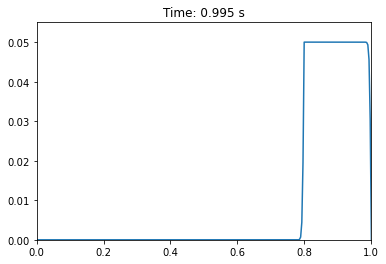

In [15]:
plot_sol_in_time(t,x,U_up_2)

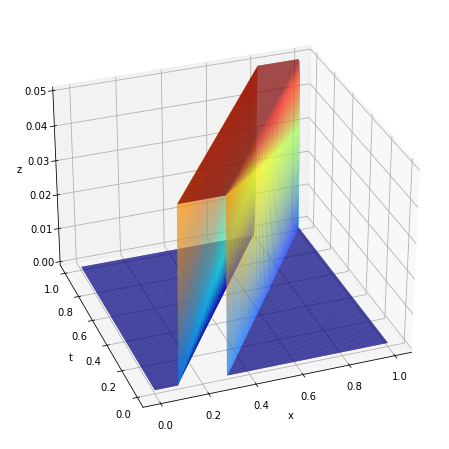

In [16]:
plot_sol_in_3d(t,x,U_up_2)

In [17]:
um.N_x = 120
um.N_t = 200

x = um.x_array()
t = um.t_array()

U_up_2 = um.compute_solution()

print(um.courant_number())

0.42


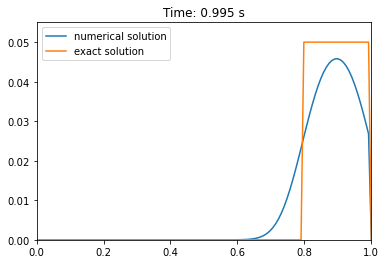

In [18]:
plot_sol_in_time(t,x,U_up_2,exact_sol)

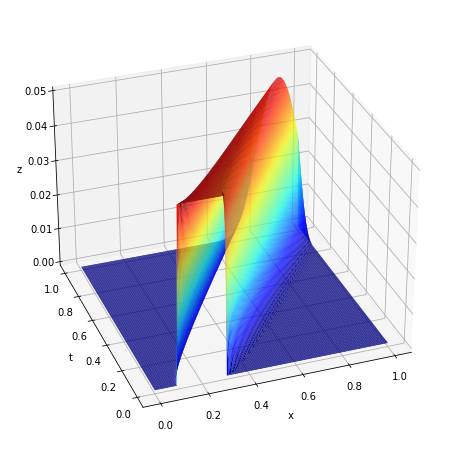

In [19]:
plot_sol_in_3d(t,x,U_up_2)

## Lax-Wendroff method

In [20]:
class lw_2(ad_pb_fd_method):
    
    def __init__(self, alpha, u_0, g, a = 0, b = 1, T = 1):
        super().__init__(alpha, u_0, g, a, b, T)
        self.name = "Lax-Wendroff"
        
    def compute_solution(self):
        
        eta = self.courant_number()
        if eta > 1:
            print("The method is unstable! CFL number = ", eta)
            
        U = np.zeros((self.N_t,self.N_x))
        coeffs = [.5 * eta * (1 + eta) * np.ones(self.N_x-1),(1 - eta**2) * np.ones(self.N_x),-0.5 * eta * (1 - eta) * np.ones(self.N_x-1)]
        A = sp.diags(coeffs,[-1,0,1], format="csr")
        
        u_0 = np.vectorize(self.u_0)
        g = np.vectorize(self.g)       
        U[0,:] = u_0(self.x_array())
        bc = 0 if self.alpha > 0 else self.N_x - 1
        U[:,bc] = g(self.t_array())
        for i in range(1,self.N_t):
            U[i,:] = A.dot(U[i-1,:])
        
        return U

In [21]:
class lax_wendroff(ad_pb_fd_method):
    
    def __init__(self, alpha, u_0, g, a = 0, b = 1, T = 1):
        super().__init__(alpha, u_0, g, a, b, T)
        self.name = "Lax-Wendroff"
        
    def compute_solution(self):
        
        if self.courant_number() > 1:
            print("The method is unstable! CFL number = ", self.courant_number())
            
        U = np.zeros((self.N_t, self.N_x))
        coeffs = []
        indexes = []
        
        u_0_np = np.vectorize(self.u_0)
        g_np = np.vectorize(self.g)        
        U[0,:] = u_0_np(self.x_array())
        bc = 0 if self.alpha(0,0) >= 0 else self.N_x - 1
        U[:,0] = g_np(self.t_array())
        #U[:,-1] = g_np(self.t_array())
        A = sp.lil_matrix((self.N_x,self.N_x))
        eta = self.tau() / self.h()
        
        for n in range(1,self.N_t):
            for j in range(self.N_x):
                alpha_n_dot_5 = self.alpha((n + 0.5) * self.tau(),self.a + j*self.h())
                alpha_n_j = self.alpha(n * self.tau(), self.a + j*self.h())
                alpha_j_dot_5 = self.alpha(n * self.tau(), self.a + (j + 0.5) * self.h())
                alpha_j_min_dot_5 = self.alpha(n * self.tau(), self.a + (j - 0.5) * self.h())
                if j > 0:
                    A[j,j-1] = 0.5 * eta * (alpha_n_dot_5 + eta * alpha_n_j * alpha_j_min_dot_5)
                A[j,j] = 1 - 0.5 * eta**2 * alpha_n_j * (alpha_j_dot_5 + alpha_j_min_dot_5)
                if j < self.N_x - 1:
                    A[j,j+1] = - 0.5 * eta * (alpha_n_dot_5 - eta * alpha_n_j * alpha_j_dot_5)
            U[n,:] = A.dot(U[n-1,:])
            U[n,0] = self.g(self.tau() * n)
            #U[n,-1] = self.g(self.tau() * n)
        
        return U

In [22]:
def u_0(x):
    return 10**4*(0.1 - x)**2*(0.2-x)**2 if 0.1 < x and x < 0.2 else 0.0
def alpha(t,x):
    return 0.7

lw = lax_wendroff(alpha,u_0,g)

lw.N_t = 200
lw.N_x = 250

U_lw = lw.compute_solution()

x = lw.x_array()
t = lw.t_array()

print(lw.courant_number())

0.8749999999999999


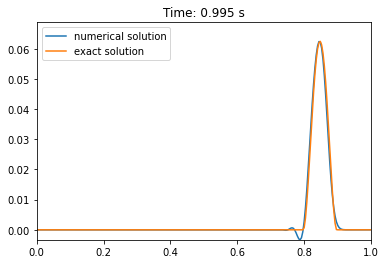

In [23]:
plot_sol_in_time(t,x,U_lw,exact_sol)

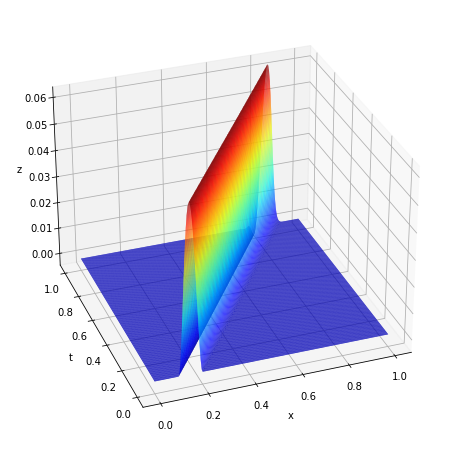

In [24]:
plot_sol_in_3d(t,x,U_lw)

In [25]:
def compare_fd_at(fd_1,fd_2,timestamps, exact_sol = None):
    U_1 = fd_1.compute_solution()
    U_2 = fd_2.compute_solution()
    cols = 2
    rows = (len(timestamps) - 1) // cols + 1
    fig, axs = plt.subplots(rows, cols, figsize = (18,12))
    axs = axs.flat
    for k in range(len(axs)):
        if k < len(timestamps):
                i_1 = fd_1.index_at_t(timestamps[k])
                i_2 = fd_2.index_at_t(timestamps[k])
                axs[k].plot(fd_1.x_array(),U_1[i_1], label=fd_1.name)
                axs[k].plot(fd_2.x_array(),U_2[i_2], label=fd_2.name)
                if exact_sol is not None:
                    axs[k].plot(fd_1.x_array(),np.vectorize(exact_sol)(timestamps[k],fd_1.x_array()),label="exact solution")
                    axs[k].legend()
                axs[k].set_title("t = " + str(timestamps[k]) + " --- Courant number: " + str(round(fd_1.courant_number(),3)))
        else:
            fig.delaxes(axs[k])

0.8049999999999999
0.42


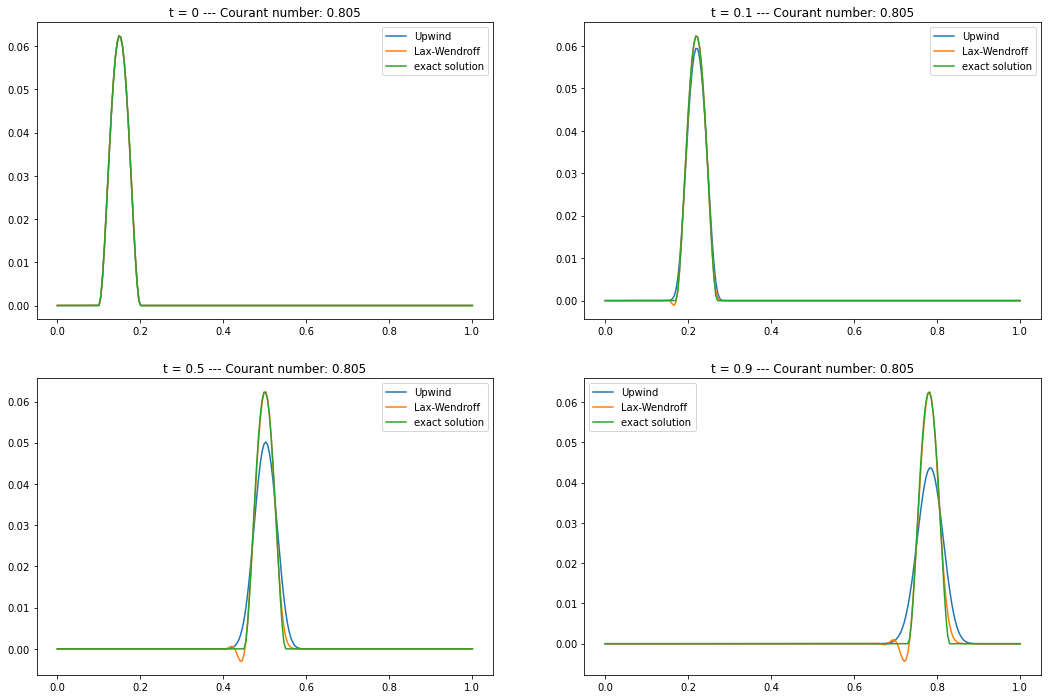

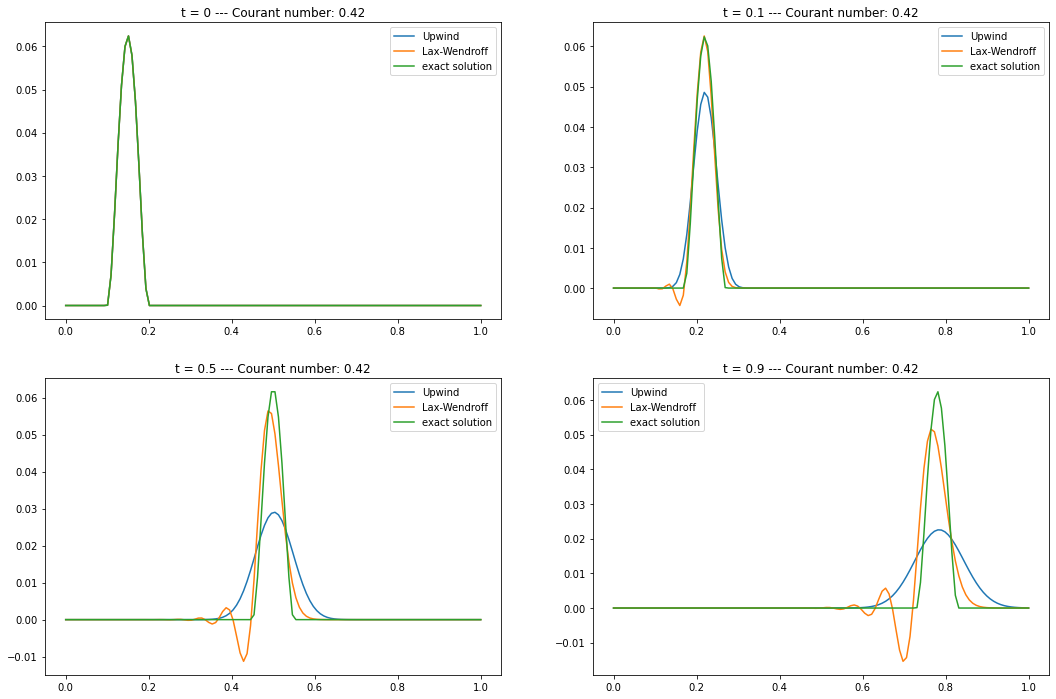

In [26]:
um.u_0 = u_0
um.alpha = alpha
for (n_x,n_t) in [(230,200), (120,200)]:
    um.N_x = n_x
    um.N_t = n_t
    lw.N_x = n_x
    lw.N_t = n_t
    print(um.courant_number())
    compare_fd_at(um,lw,[0,0.1,0.5,0.9],exact_sol)

0.8049999999999999
0.42


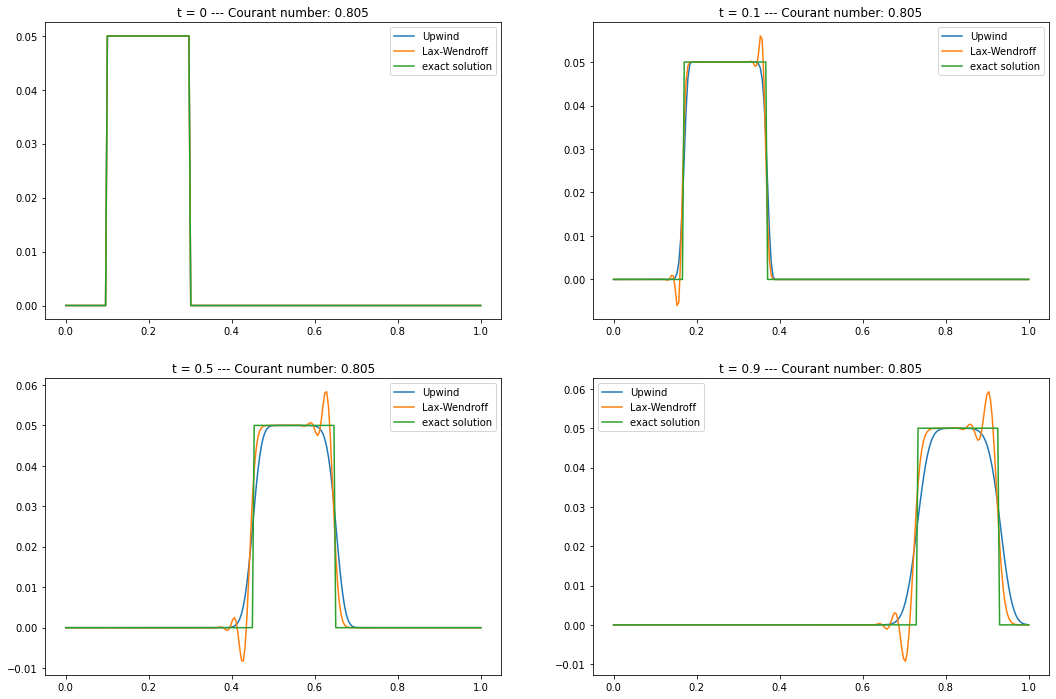

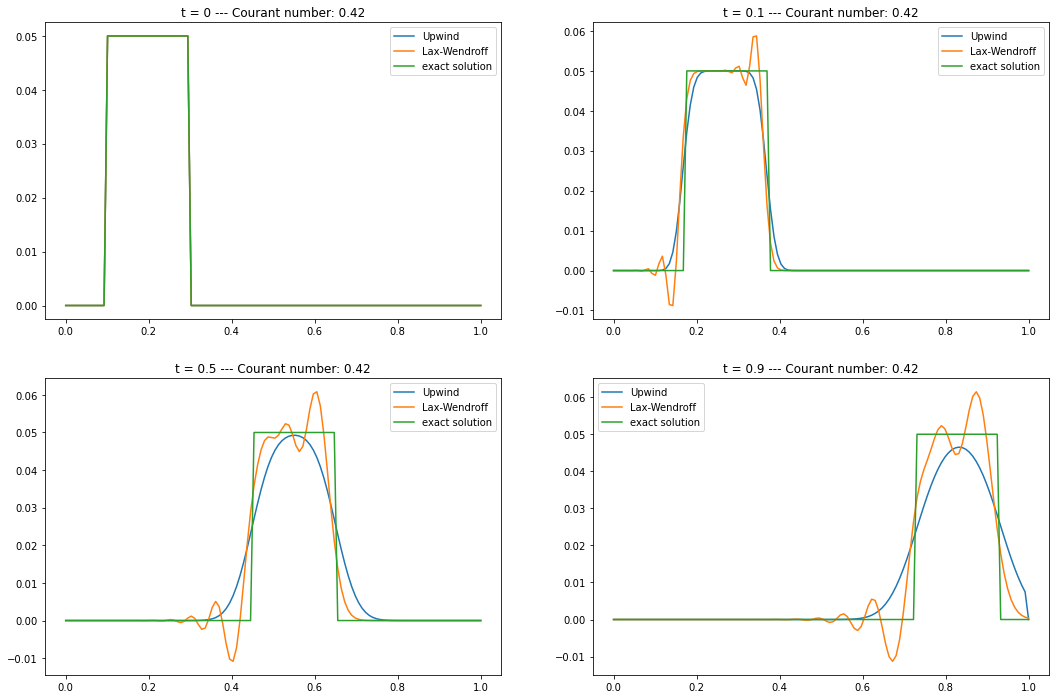

In [27]:
def u_0(x):
    return 0.05 if 0.1 < x and x < 0.3 else 0.0
um.u_0 = u_0
lw.u_0 = u_0
for (n_x,n_t) in [(230,200), (120,200)]:
    um.N_x = n_x
    um.N_t = n_t
    lw.N_x = n_x
    lw.N_t = n_t
    print(um.courant_number())
    compare_fd_at(um,lw,[0,0.1,0.5,0.9],exact_sol)

In [28]:
def g_1(t):
    return -0.06 * np.sin(2*np.pi*t)
um.alpha = lambda t,x : 1 
um.N_x = 250
um.N_t = 250
um.g = g_1
um.u_0 = lambda x : 0.06 * np.sin(2*np.pi*x)
U_up_3 = um.compute_solution()

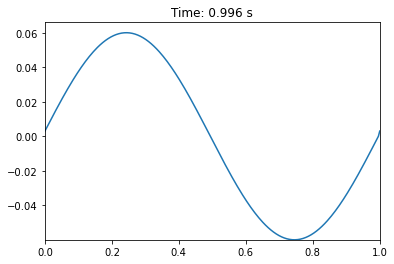

In [29]:
plot_sol_in_time(um.t_array(),um.x_array(),U_up_3)

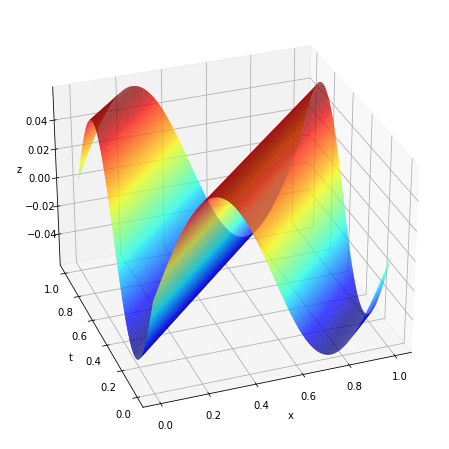

In [30]:
plot_sol_in_3d(um.t_array(),um.x_array(),U_up_3)

## Leapfrog method

In [31]:
class leapfrog(ad_pb_fd_method):
    
    def __init__(self, alpha, u_0, g, a = 0, b = 1, T = 1):
        super().__init__(alpha, u_0, g, a, b, T)
        self.name = "Leapfrog"
        
    def compute_solution(self):
        
        if self.courant_number() > 1:
            print("The method is unstable! CFL number = ", self.courant_number())
            
        U = np.zeros((self.N_t, self.N_x))
        A = sp.lil_matrix((self.N_x,self.N_x))
        
        u_0_np = np.vectorize(self.u_0)
        g_np = np.vectorize(self.g)        
        U[0,:] = u_0_np(self.x_array())
        #bc = 0 if self.alpha >= 0 else self.N_x - 1
        U[:,0] = g_np(self.t_array())
        U[:,-1] = g_np(self.t_array())
        eta = self.alpha(self.tau(),self.a + self.h()) * self.tau() / self.h()
        coeffs_1 = [.5 * eta * (1 + eta) * np.ones(self.N_x-1),(1 - eta**2) * np.ones(self.N_x),-0.5 * eta * (1 - eta) * np.ones(self.N_x-1)]
        A_1 = sp.diags(coeffs_1,[-1,0,1], format="csr")
        U[1,:] = A_1.dot(U[0,:])
        U[1,0] = self.g(self.tau())
        U[1,-1] = self.g(self.tau())
        
        for n in range(2,self.N_t):
            for j in range(self.N_x):
                if j < self.N_x - 1:
                    A[j,j+1] = -self.alpha(self.tau() * n, self.a + self.h() * j) * self.tau() / self.h()
                if j > 0:
                    A[j,j-1] = self.alpha(self.tau() * n, self.a + self.h() * j) * self.tau() / self.h()
            U[n,:] = A.dot(U[n-1,:]) + U[n-2,:]
            U[n,0] = self.g(self.tau() * n)
            U[n,-1] = self.g(self.tau() * n)
        
        return U

In [32]:
def u_0(x):
    return 10**4*(0.1 - x)**2*(0.2-x)**2 if 0.1 < x and x < 0.2 else 0.0
g = lambda x : 0
def alpha(t,x):
    return 0.7
def exact_sol(t,x):
    return u_0(x - 0.7*t)

In [33]:
lp = leapfrog(alpha,u_0,g)

lp.N_x = 285
lp.N_t = 200

x = lp.x_array()
t = lp.t_array()

U_lp = lp.compute_solution()

print(lp.courant_number())

0.9974999999999998


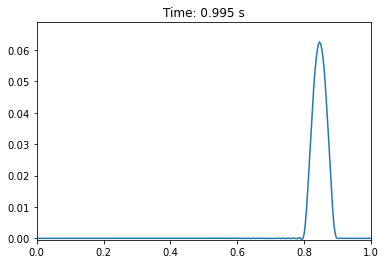

In [34]:
plot_sol_in_time(t,x,U_lp)

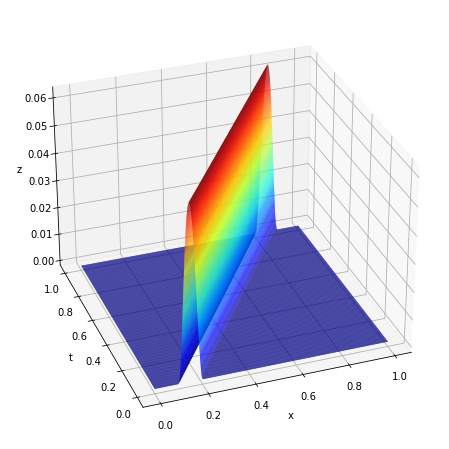

In [35]:
plot_sol_in_3d(t,x,U_lp)

0.8049999999999999
0.42


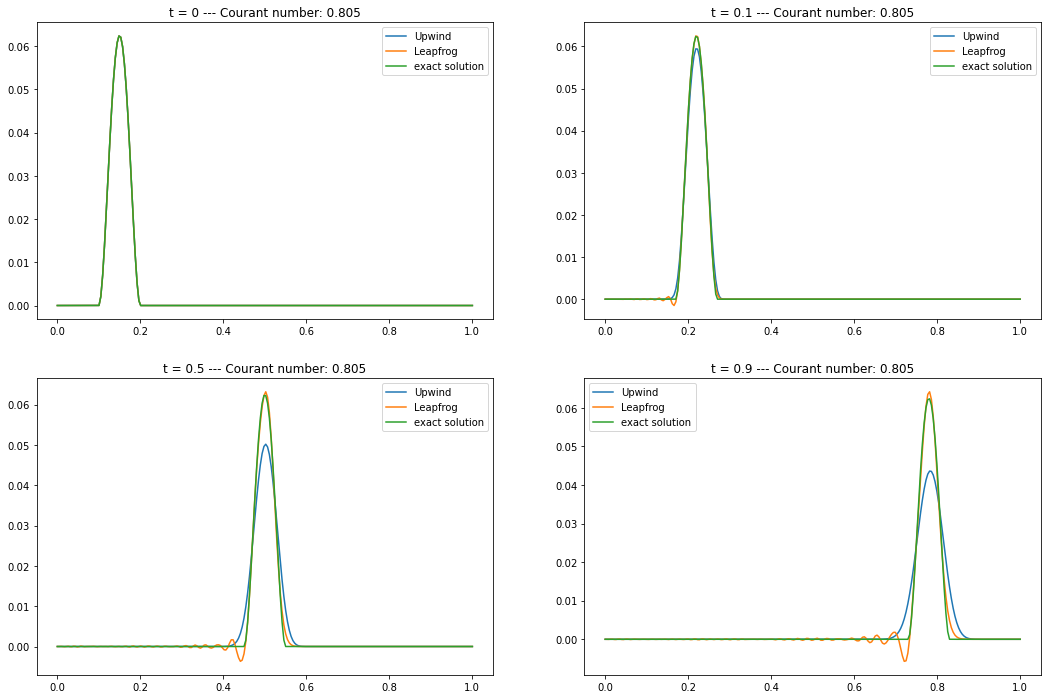

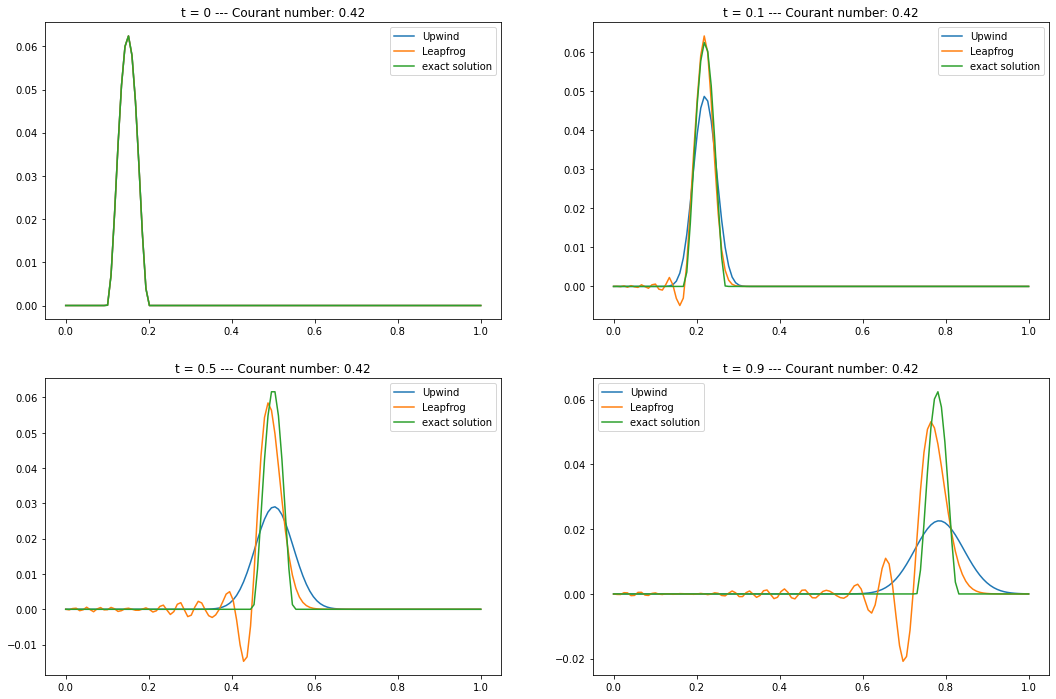

In [36]:
um.u_0 = u_0
um.g = g
um.alpha = alpha

for (n_x,n_t) in [(230,200), (120,200)]:
    um.N_x = n_x
    um.N_t = n_t
    lp.N_x = n_x
    lp.N_t = n_t
    print(um.courant_number())
    compare_fd_at(um,lp,[0,0.1,0.5,0.9],exact_sol)

0.8049999999999999
0.42


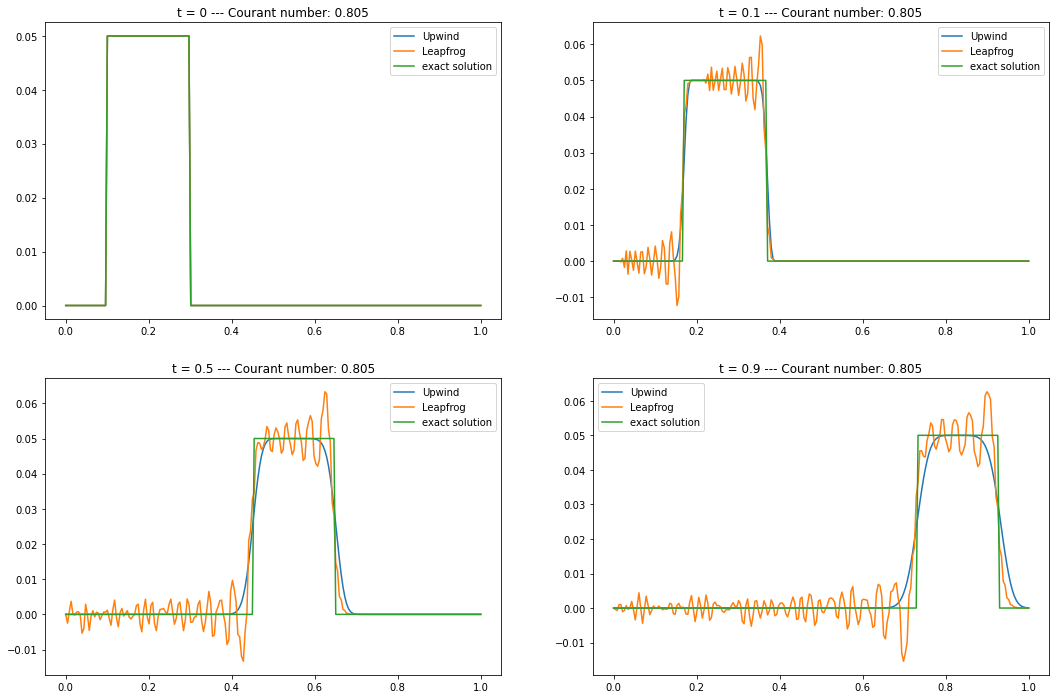

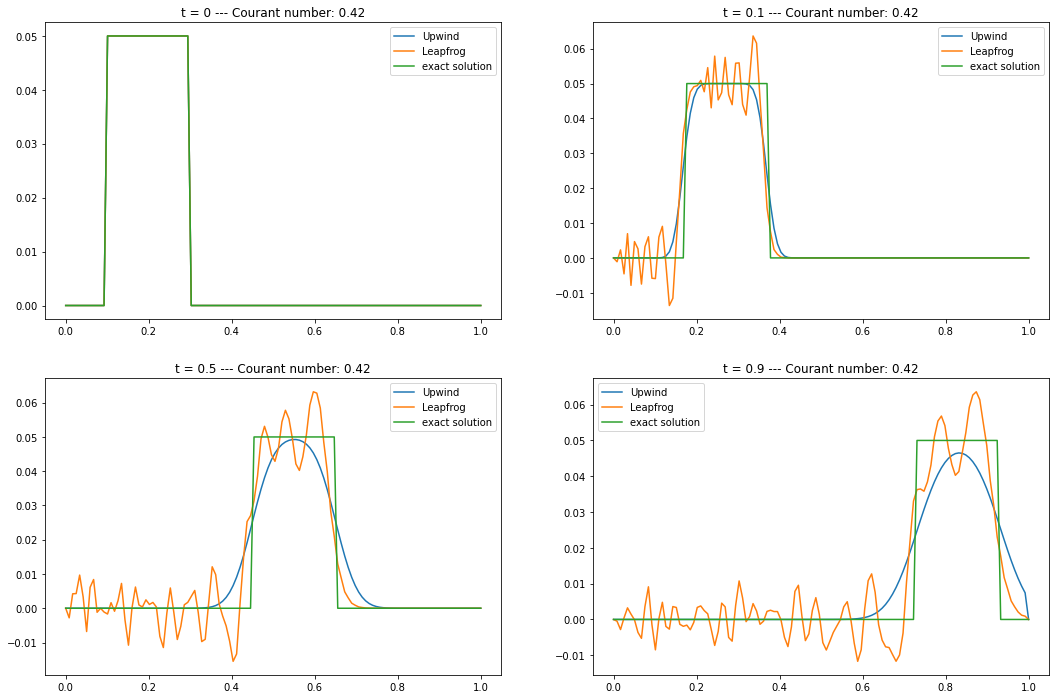

In [37]:
def u_0(x):
    return 0.05 if 0.1 < x and x < 0.3 else 0.0
um.u_0 = u_0
lp.u_0 = u_0
for (n_x,n_t) in [(230,200), (120,200)]:
    um.N_x = n_x
    um.N_t = n_t
    lp.N_x = n_x
    lp.N_t = n_t
    print(um.courant_number())
    compare_fd_at(um,lp,[0,0.1,0.5,0.9],exact_sol)

## Box scheme

In [38]:
class box(ad_pb_fd_method):
    
    def __init__(self, alpha, u_0, g, a = 0, b = 1, T = 1):
        super().__init__(alpha, u_0, g, a, b, T)
        self.name = "Box"
        
    def compute_solution(self):
            
        U = np.zeros((self.N_t, self.N_x))        
        u_0_np = np.vectorize(self.u_0)
        g_np = np.vectorize(self.g)        
        U[0,:] = u_0_np(self.x_array())
        U[:,0] = g_np(self.t_array())
     #   U[:,-1] = g_np(self.t_array())
        
        for n in range(self.N_t - 1):
            for j in range(self.N_x - 1):
                eta = self.alpha((n + 0.5) * self.tau(), self.a + (j + 0.5) * self.h()) * self.tau() / self.h()
                U[n+1,j+1] = U[n,j] + (1 - eta)/(1 + eta)*(U[n,j+1] - U[n+1,j])
                U[n+1,0] = self.g((n+1) * self.tau())
          #      U[n+1,-1] = self.g((n+1) * self.tau())
        
        return U

In [39]:
def u_0(x):
    return 10**4*(0.1 - x)**2*(0.2-x)**2 if 0.1 < x and x < 0.2 else 0.0
g = lambda x : 0
def alpha(t,x):
    return 0.7
def exact_sol(t,x):
    return u_0(x - 0.7*t)

In [40]:
bx = box(alpha,u_0,g)

bx.N_x = 285
bx.N_t = 200

x = bx.x_array()
t = bx.t_array()

U_bx = bx.compute_solution()

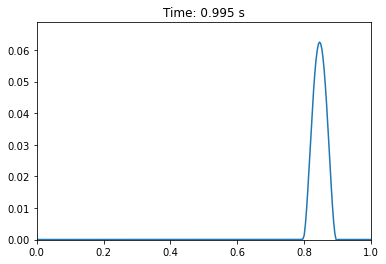

In [41]:
plot_sol_in_time(t,x,U_bx)

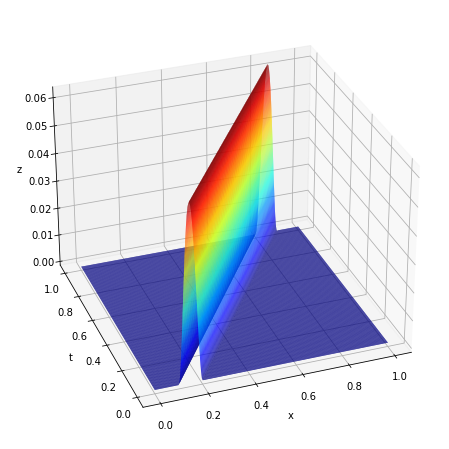

In [42]:
plot_sol_in_3d(t,x,U_bx)

0.8049999999999999
0.42


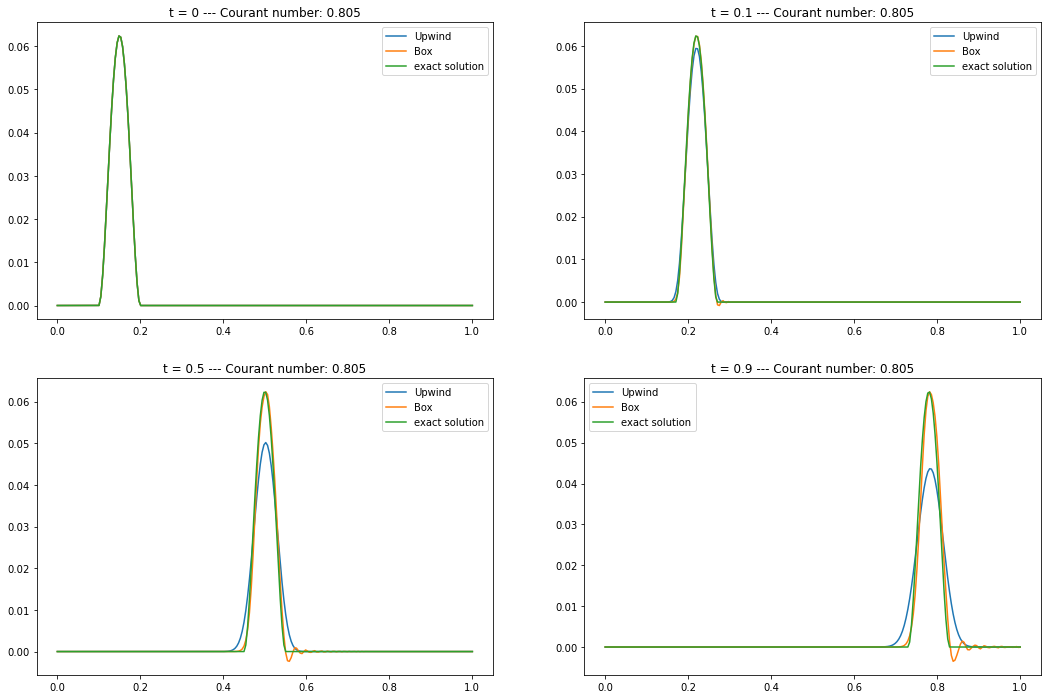

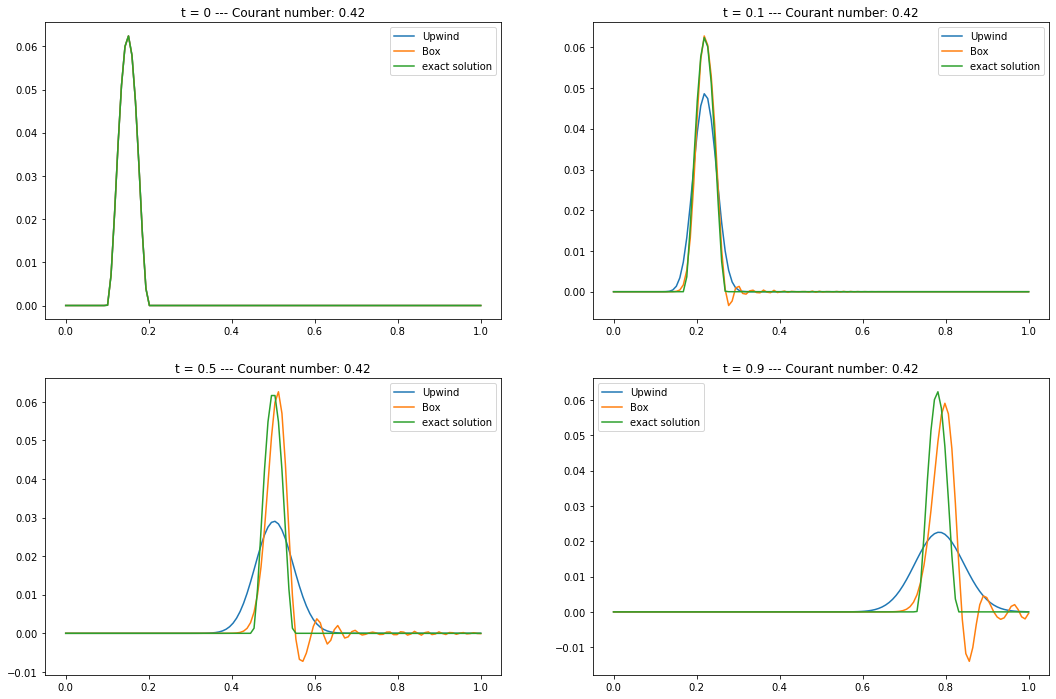

In [43]:
um.u_0 = u_0
um.g = g
um.alpha = alpha

for (n_x,n_t) in [(230,200), (120,200)]:
    um.N_x = n_x
    um.N_t = n_t
    bx.N_x = n_x
    bx.N_t = n_t
    print(um.courant_number())
    compare_fd_at(um,bx,[0,0.1,0.5,0.9],exact_sol)

0.8049999999999999
0.42


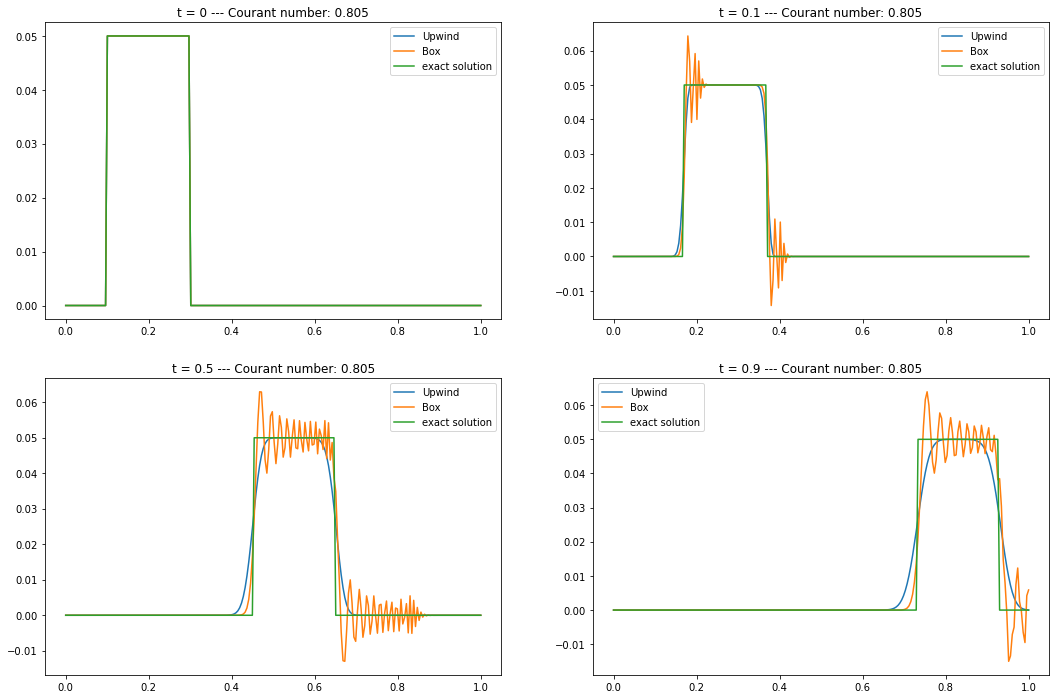

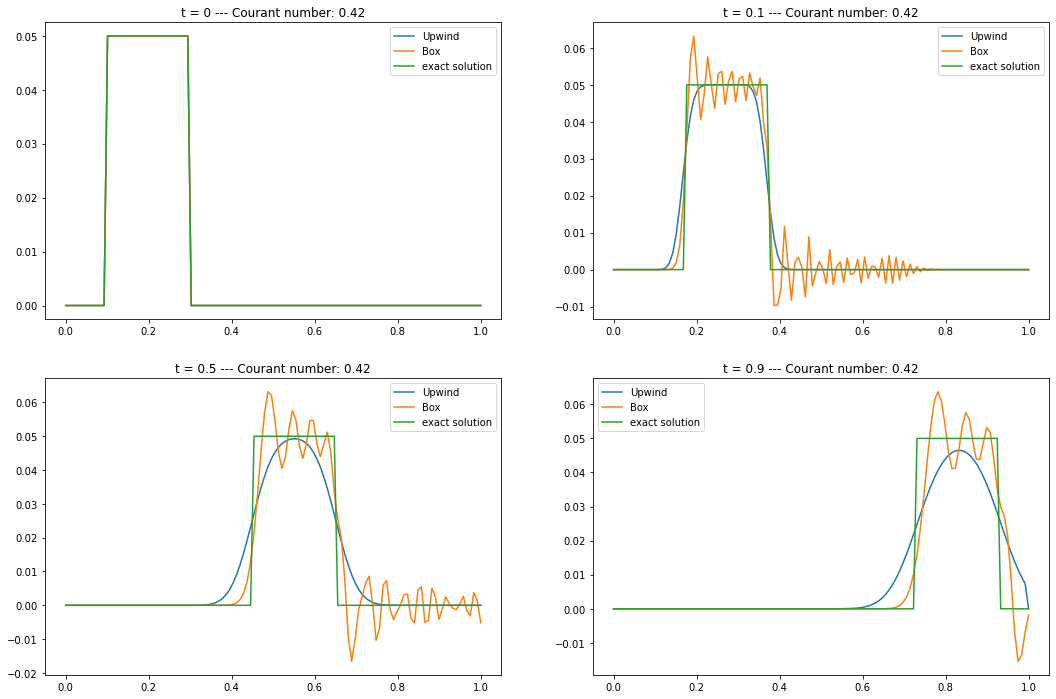

In [45]:
def u_0(x):
    return 0.05 if 0.1 < x and x < 0.3 else 0.0
um.u_0 = u_0
bx.u_0 = u_0
for (n_x,n_t) in [(230,200), (120,200)]:
    um.N_x = n_x
    um.N_t = n_t
    bx.N_x = n_x
    bx.N_t = n_t
    print(um.courant_number())
    compare_fd_at(um,bx,[0,0.1,0.5,0.9],exact_sol)

In [70]:
class lax_wendroff_cons(ad_pb_fd_method):
    
    def __init__(self, alpha, u_0, g, a = 0, b = 1, T = 1):
        super().__init__(alpha, u_0, g, a, b, T)
        self.name = "Lax-Wendroff"
    
    def courant_number(self):
        return 0.9
    
    def compute_solution(self):
        
        if self.courant_number() > 1:
            print("The method is unstable! CFL number = ", self.courant_number())
            
        U = np.zeros((self.N_t, self.N_x))
        
        u_0_np = np.vectorize(self.u_0)
        g_np = np.vectorize(self.g)        
        U[0,:] = u_0_np(self.x_array())
        U[:,0] = g_np(self.t_array())
        U[:,-1] = g_np(self.t_array())
        F = sp.lil_matrix((self.N_x,self.N_x))
        mu = self.tau()/self.h()
        f = self.alpha
        f_np = np.vectorize(self.alpha)

        for n in range(self.N_t - 1):
            for j in range(self.N_x):
                F_n_j = f(U[n,j])
                if j < self.N_x - 1:
                    F_n_j_p_1 = f(U[n,j+1])
                    a_n_j_p_dot_5 = (F_n_j_p_1 - F_n_j)/(U[n,j+1] - U[n,j])
                    F[j,j + 1] = (1 - a_n_j_p_dot_5 * mu)
                    F[j,j] += mu * a_n_j_p_dot_5
                if j > 0:
                    F_n_j_m_1 = f(U[n,j-1])
                    a_n_j_m_dot_5 = (F_n_j - F_n_j_m_1)/(U[n,j] - U[n,j-1])
                    F[j,j - 1] = -(1 + a_n_j_m_dot_5 * mu)
                    F[j,j] += mu * a_n_j_m_dot_5
            U[n+1,:] = U[n,:] - 0.5 * mu * F.dot(f_np(U[n,:]))
            U[n+1,0] = self.g(self.tau() * n)
            U[n+1,-1] = self.g(self.tau() * n)
        
        return U

In [71]:
def u_0(x):
    return np.exp(-10*(4*x-1)**2)
g = lambda x : 0
def f(u):
    return 0.5 * (u**2)
def exact_sol(t,x):
    return u_0(x - 0.7*t)

In [74]:
lw_c = lax_wendroff_cons(f,u_0,g,T=0.4)

lw_c.N_x = 250
lw_c.N_t = 500

x = lw_c.x_array()
t = lw_c.t_array()

U_lw_c = lw_c.compute_solution()

0.0


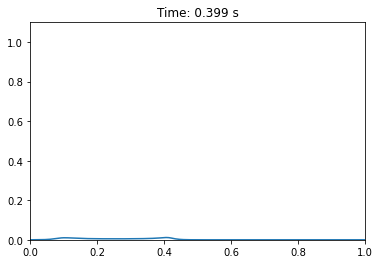

In [75]:
plot_sol_in_time(t,x,U_lw_c,wait=0.5)

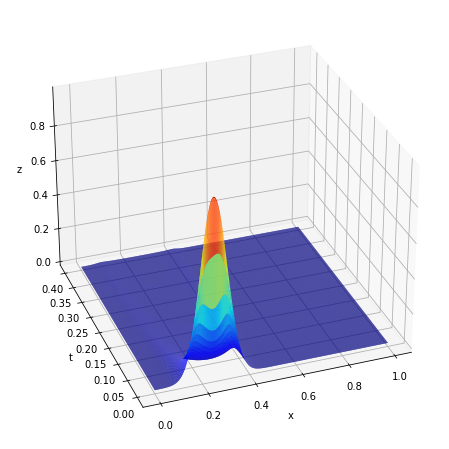

In [64]:
plot_sol_in_3d(t,x,U_lw_c)